In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import get_value, set_value
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

In [5]:
device = torch.device('cpu:0')

In [2]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce RTX 2080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [22]:
sns.axes_style()
sns.set_style("white")
sns.set_context("notebook", rc={'axes.labelsize': 12.0, 'axes.titlesize': 14.0, 'legend.fontsize': 12.0, 'xtick.labelsize': 12.0, 'ytick.labelsize': 12.0})
sns.set_palette("deep")
plt.rcParams['image.cmap'] = 'viridis'

In [70]:
nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
mask_root = nsd_root + "nsddata/ppdata/"

subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}

timestamp = 'May-22-2021_1814'

# timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'gabor_fwrf'

root_dir   = os.path.dirname(os.getcwd())
net_dir    = root_dir + "net/" 

# input_dir  = '/home/styvesg/repo.data/results/nsd/torch_fwrf_full_brain/S%02d/dnn_fwrf_May-10-2020_1814/'
output_dir = os.path.join(root_dir, 'gabor_model_fits','S%02d'%subject,'%s_%s/'% (model_name,timestamp) )

In [71]:
# Loading the results of model fitting performed with fit_model.py

fns = os.listdir(output_dir)
fns = [fn for fn in fns if 'model_params' in fn]
print(fns)
out = torch.load(os.path.join(output_dir, fns[0]))
print(out.keys())

group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]
n_rois = len(group_names)


['model_params_fakerandomdata']
dict_keys(['feature_table', 'sf_tuning_masks', 'ori_tuning_masks', 'cyc_per_stim', 'orients_deg', 'orient_filters', 'aperture', 'models', 'image_order', 'best_params', 'lambdas', 'best_lambdas', 'best_losses', 'val_cc', 'val_r2', 'features_each_model_val', 'covar_each_model_training', 'voxel_feature_correlations_val', 'zscore_features', 'nonlin_fn', 'debug'])


In [73]:
# Pulling out useful elements from the saved data

feature_table = out['feature_table']
orient_list = np.round(np.array(feature_table['orientation'])/np.pi*180,1)
a,orient_ind_list = np.unique(orient_list,return_inverse=True)
sf_list = np.array(feature_table['cycles per stimulus'])
a,sf_ind_list = np.unique(sf_list,return_inverse=True)

aperture = out['aperture']
cyc_per_stim  = out['cyc_per_stim']
orients_deg = out['orients_deg']

sf_tuning_masks = out['sf_tuning_masks']
ori_tuning_masks = out['ori_tuning_masks']
orient_filters = out['orient_filters']

# voxel_mask = out['voxel_mask']
# brain_nii_shape = out['brain_nii_shape']
image_order = out['image_order']
# voxel_idx = out['voxel_index']
# voxel_roi = out['voxel_roi']

val_cc = out['val_cc']
best_params = out['best_params']
best_lambdas = out['best_lambdas']
best_losses = out['best_losses']
lambdas = out['lambdas']

features_each_model_val = out['features_each_model_val']
voxel_feature_correlations_val = out['voxel_feature_correlations_val']
covar_each_model_training = out['covar_each_model_training']
                                     
zscore_features = out['zscore_features']
nonlin_fn = out['nonlin_fn']

# Best params[0] = x,y,sigma for pRF estimates [n_voxels x 3]
print(np.shape(best_params[0]))
# Best params[1] = best weights [n_voxels x nFeatures]
print(np.shape(best_params[1]))

best_models = best_params[0]
best_model_inds = best_params[5]
best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

feature_weights = best_params[1]

n_sf = len(cyc_per_stim)
n_ori = len(orients_deg)
n_voxels = np.shape(feature_weights)[0]
n_features_total = np.shape(feature_weights)[1]

(1000, 3)
(1000, 432)


In [74]:
from src.rf_grid    import  logspace, model_space_pyramid

aperture = np.float32(1)
smin, smax = np.float32(0.04), np.float32(0.4)
n_sizes = 8

# models is three columns, x, y, sigma
models = model_space_pyramid(logspace(n_sizes)(smin, smax), min_spacing=1.4, aperture=1.1*aperture) 

In [6]:
np.unique(voxel_roi)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [7]:
np.shape(voxel_feature_correlations_val)

(11694, 432)

In [9]:
feature_table

,cycles per stimulus,pix per stimulus,orientation,cycles per filter,pix per filter,gauss. env. radius (pix)
0,3.0,12,0.000000,2.8,12.0,2.891
1,3.0,12,0.087266,2.8,12.0,2.891
2,3.0,12,0.174533,2.8,12.0,2.891
3,3.0,12,0.261799,2.8,12.0,2.891
4,3.0,12,0.349066,2.8,12.0,2.891
...,...,...,...,...,...,...
427,72.0,297,2.705260,2.8,12.0,2.891
428,72.0,297,2.792527,2.8,12.0,2.891
429,72.0,297,2.879793,2.8,12.0,2.891
430,72.0,297,2.967060,2.8,12.0,2.891


In [11]:
lambdas

array([0., 0., 0.])

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


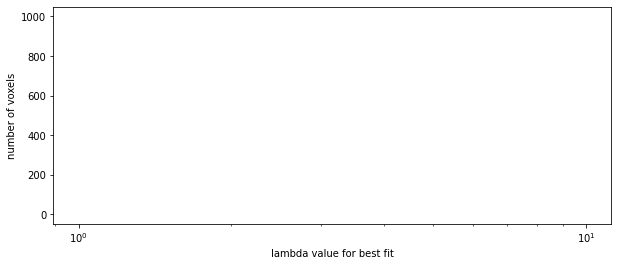

In [75]:
# Plot best lambda values for all voxels

plt.figure(figsize=(10,4))
# lambdas = np.logspace(0.,5.,9, dtype=np.float32)
plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log');
plt.xlabel('lambda value for best fit');
plt.ylabel('number of voxels');

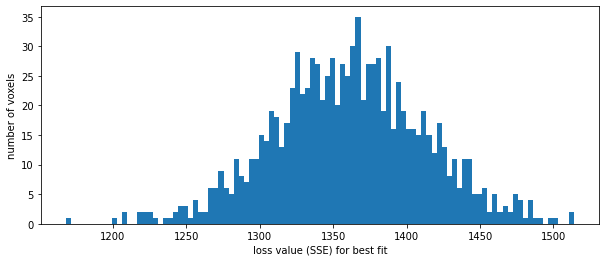

In [76]:
# Plot best loss values for all voxels

plt.figure(figsize=(10,4))
plt.hist(best_losses,100)
plt.xlabel('loss value (SSE) for best fit');
plt.ylabel('number of voxels');

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if __name__ == '__main__':


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 11694

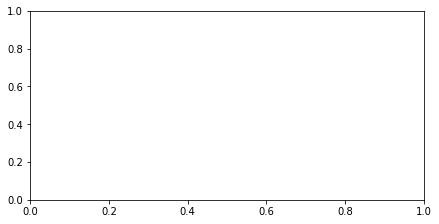

In [77]:
# Plot correlation coefficient for validation set, each voxel.
plt.figure(figsize=(24,16))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    plt.subplot(npx,npy,rr+1)

    h = plt.hist(val_cc[inds_this_roi], bins=np.linspace(-0.2,1,100))

    if rr==n_rois-2:
        plt.xlabel('correlation coefficient')
        plt.ylabel('number of voxels')
#     else:
#         plt.xticks([])
#         plt.yticks([])
        
    plt.axvline(0,color='k')
    
    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds_this_roi)))

plt.suptitle('Correlation coef. on validation set')

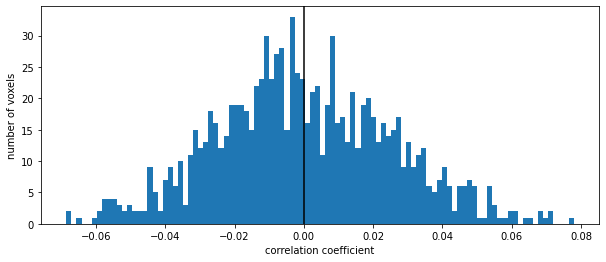

In [78]:
# Plot correlation coefficient for validation set, each voxel.

plt.figure(figsize=(10,4))
plt.hist(val_cc,100)
plt.xlabel('correlation coefficient');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')


Text(0, 0.5, 'validation set rho')

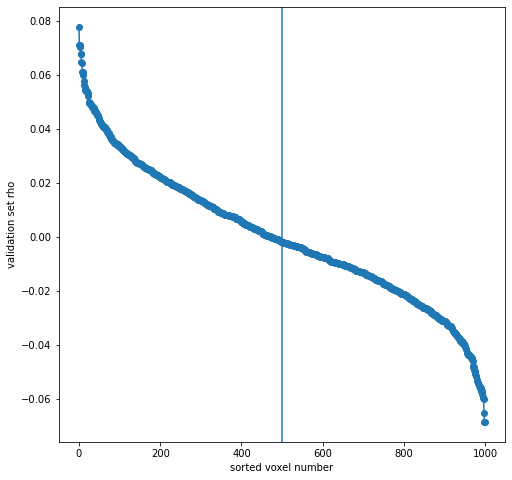

In [79]:
# Plot sorted correlation coefficients

plt.figure(figsize=(8,8))
# best_cc_vals = np.argsort(val_cc)
plt.plot(np.sort(val_cc)[::-1],'-o')
plt.axvline(500)
plt.xlabel('sorted voxel number')
plt.ylabel('validation set rho')

In [80]:
# Visualize some basic properties of pRFs for each voxel, in volume space
# Should be sanity check for dorsal/visual distinctions, esp w/r/t RF angle estimates

from src.file_utility import view_data

volume_loss = view_data(brain_nii_shape, voxel_idx, best_losses)
volume_cc   = view_data(brain_nii_shape, voxel_idx, val_cc, save_to=output_dir+"val_cc")
volume_ecc  = view_data(brain_nii_shape, voxel_idx, best_ecc, save_to=output_dir+"rf_ecc")
volume_ang  = view_data(brain_nii_shape, voxel_idx, best_ang, save_to=output_dir+"rf_ang")
volume_size = view_data(brain_nii_shape, voxel_idx, best_size, save_to=output_dir+"rf_size")
volume_roi = view_data(brain_nii_shape, voxel_idx, voxel_roi, save_to=output_dir+"roi_labels")

slice_idx = 40
fig = plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('Loss')
plt.imshow(volume_loss[:,:,slice_idx], cmap='gray', interpolation='None')
plt.colorbar()
plt.subplot(2,3,2)
plt.title('Validation accuracy')
plt.imshow(volume_cc[:,:,slice_idx], cmap='hot', interpolation='None')
plt.colorbar()
plt.subplot(2,3,3)
plt.title('RF Eccentricity')
plt.imshow(volume_ecc[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(2,3,4)
plt.title('RF Angle')
plt.imshow(volume_ang[:,:,slice_idx], cmap='hsv', interpolation='None')
plt.colorbar()
plt.subplot(2,3,5)
plt.title('RF Size')
plt.imshow(volume_size[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(2,3,6)
plt.title('ROI labels')
plt.imshow(volume_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

ValueError: shape mismatch: value array of shape (1000,)  could not be broadcast to indexing result of shape (11694,)

In [81]:
# Assessing spatial frequency and orientation tuning

allcorrs_reshaped = np.reshape(voxel_feature_correlations_val, [n_voxels, n_ori, n_sf], order='F')

mean_orient_corrs = np.mean(allcorrs_reshaped, axis=2)
print(np.shape(mean_orient_corrs))
mean_sf_corrs = np.mean(allcorrs_reshaped, axis=1)
print(np.shape(mean_sf_corrs))

max_orient_corr_ind = np.argmax(mean_orient_corrs, axis=1)
preferred_ori_corrs = orients_deg[max_orient_corr_ind]

max_sf_corr_ind = np.argmax(mean_sf_corrs, axis=1)
preferred_sf_corrs = cyc_per_stim[max_sf_corr_ind]



allw_reshaped = np.reshape(feature_weights, [n_voxels, n_ori, n_sf], order='F')

mean_orient_weights = np.mean(allw_reshaped, axis=2)
print(np.shape(mean_orient_weights))
mean_sf_weights = np.mean(allw_reshaped, axis=1)
print(np.shape(mean_sf_weights))

max_orient_weight_ind = np.argmax(mean_orient_weights, axis=1)
preferred_ori_weights = orients_deg[max_orient_weight_ind]

max_sf_weight_ind = np.argmax(mean_sf_weights, axis=1)
preferred_sf_weights = cyc_per_stim[max_sf_weight_ind]


(1000, 36)
(1000, 12)
(1000, 36)
(1000, 12)


In [82]:
# double check that the reshaping was done correctly
sf=0
oo=0
print(allw_reshaped[0,:,sf])
print(feature_weights[0,sf_tuning_masks[sf]])
print(allcorrs_reshaped[0,:,sf])
print(voxel_feature_correlations_val[0,sf_tuning_masks[sf]])

print(allw_reshaped[0,oo,:])
print(feature_weights[0,ori_tuning_masks[oo]])
print(allcorrs_reshaped[0,oo,:])
print(voxel_feature_correlations_val[0,ori_tuning_masks[oo]])


[ 662.99133  -776.13226   477.79404  -109.789856   49.839523 -213.7538
  625.06165  -817.4225    662.1488   -580.54016   587.9759   -580.85535
  434.11615   -94.324265   97.43727  -244.77034    42.491676  270.55945
 -306.98117   154.84378   -46.350388  -12.581863  204.48688  -171.91385
 -218.70248   454.94043  -433.49042   262.05304  -247.96802   499.5577
 -439.77573    47.91207   174.57205  -271.10873   338.7928   -436.19937 ]
[ 662.99133  -776.13226   477.79404  -109.789856   49.839523 -213.7538
  625.06165  -817.4225    662.1488   -580.54016   587.9759   -580.85535
  434.11615   -94.324265   97.43727  -244.77034    42.491676  270.55945
 -306.98117   154.84378   -46.350388  -12.581863  204.48688  -171.91385
 -218.70248   454.94043  -433.49042   262.05304  -247.96802   499.5577
 -439.77573    47.91207   174.57205  -271.10873   338.7928   -436.19937 ]
[ 0.0178985   0.01954449  0.02132581  0.01727379  0.00253789 -0.01069148
 -0.0052991   0.01180004  0.01919384  0.01291904  0.00027545 -0

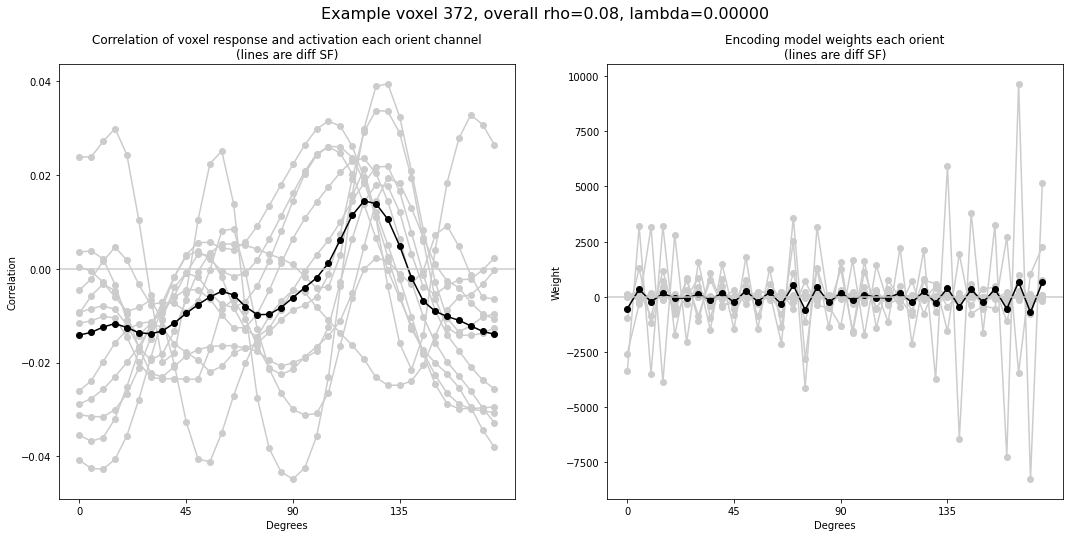

In [83]:
# Plotting orientation tuning for one example voxel

vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance

plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(orients_deg, allcorrs_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
plt.plot(orients_deg,  mean_orient_corrs[vidx,:],'-o',color='k')
plt.xlabel('Degrees')
plt.ylabel('Correlation')
plt.title('Correlation of voxel response and activation each orient channel\n(lines are diff SF)')
# plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))
# plt.ylim([0,1])

plt.subplot(1,2,2)
plt.plot(orients_deg, allw_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
plt.plot(orients_deg, mean_orient_weights[vidx,:],'-o',color='k')
plt.xlabel('Degrees')
plt.ylabel('Weight')
plt.title('Encoding model weights each orient\n(lines are diff SF)')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))
# plt.ylim([-1,1])

plt.suptitle('Example voxel %d, overall rho=%.2f, lambda=%.5f'%( vidx, val_cc[vidx],lambdas[best_lambdas[vidx]]),fontsize=16);

In [42]:
nonlin_fn

False

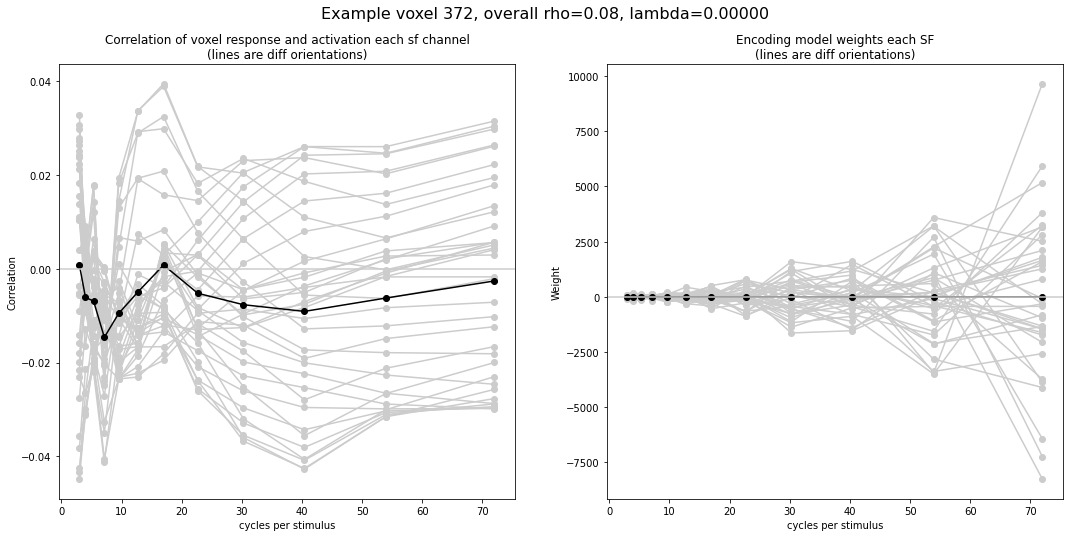

In [84]:
# Plotting SF tuning for one example voxel

vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance

plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(cyc_per_stim, np.transpose(allcorrs_reshaped[vidx,:,:]),'-o',color=[0.8, 0.8, 0.8])
plt.plot(cyc_per_stim, mean_sf_corrs[vidx,:],'-o',color='k')
plt.xlabel('cycles per stimulus')
plt.ylabel('Correlation')
plt.title('Correlation of voxel response and activation each sf channel\n(lines are diff orientations)')
# plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])
# plt.ylim([0,1])

plt.subplot(1,2,2)
plt.plot(cyc_per_stim, np.transpose(allw_reshaped[vidx,:,:]),'-o',color=[0.8, 0.8, 0.8])
plt.plot(cyc_per_stim, mean_sf_weights[vidx,:],'-o',color='k')
plt.xlabel('cycles per stimulus')
plt.ylabel('Weight')
plt.title('Encoding model weights each SF\n(lines are diff orientations)')
plt.axhline(0, color=[0.8, 0.8, 0.8])

plt.suptitle('Example voxel %d, overall rho=%.2f, lambda=%.5f'%( vidx, val_cc[vidx],lambdas[best_lambdas[vidx]]),fontsize=16);

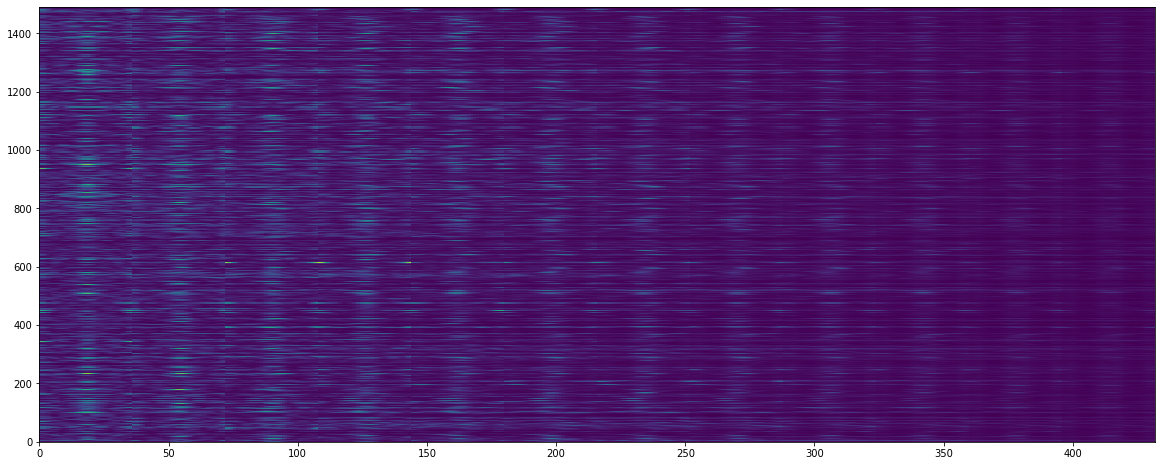

In [86]:
best_model_ind = best_model_inds[vidx]
# best_model_ind=37

# best_model_ind = np.where(np.logical_and(models[:,0]==0, models[:,1]==0))[0][0]

plt.figure(figsize=(20,8));

plt.pcolormesh(features_each_model_val[:,:,best_model_ind])

Text(0.5, 1.0, 'z-score each feature across images')

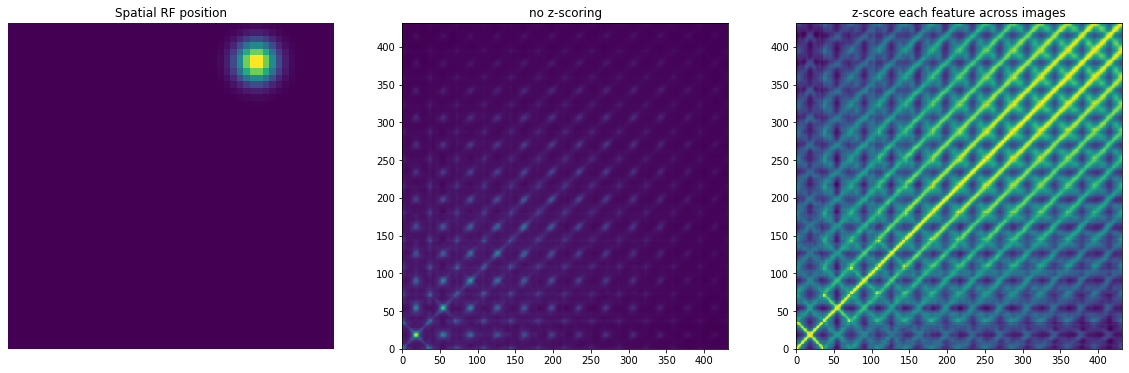

In [89]:
# visualizing covariance among features in the training set data - before and after z-scoring
# all features are nori*nsf = 432 total

from src.numpy_utility import make_gaussian_mass_stack
import scipy

x,y,sigma = np.round(models[best_model_inds[vidx]],2)
# x,y,sigma = [-0.55, -0.55, 0.04]
# x,y,sigma = [-0.33, -0.33, 0.04]
# x,y,sigma = [-0.22, -0.22, 0.04]

# x,y,sigma = [0,0, 0.04]

plt.figure(figsize=(20,6));

g = make_gaussian_mass_stack([x], [y], [sigma], n_pix=50, size=1.0, dtype=np.float32)
plt.subplot(1,3,1)
plt.pcolormesh(g[2][0])
plt.axis('equal')
plt.axis('off')
plt.title('Spatial RF position')
best_model_ind = np.where(np.logical_and(np.round(models[:,0],2)==x, np.round(models[:,1],2)==y))[0][0]

plt.subplot(1,3,2)
features_actual = features_each_model_val[:,:,best_model_ind]
covariance = np.cov(np.transpose(features_actual))
plt.pcolormesh(covariance)
# plt.colorbar()
plt.axis('square')
plt.title('no z-scoring')

plt.subplot(1,3,3)

features_actual = scipy.stats.zscore(features_each_model_val[:,:,best_model_ind], axis=0)
covariance = np.cov(np.transpose(features_actual))
plt.pcolormesh(covariance)
# plt.colorbar()
plt.axis('square')
plt.title('z-score each feature across images')
# plt.xticks(np.arange(0,35,9),labels=np.arange(0,179,45))
# plt.yticks(np.arange(0,35,9),labels=np.arange(0,179,45))

# plt.subplot(1,4,4)
# plt.pcolormesh(covar_each_model_training[:,:,best_model_ind])
# plt.axis('square')
# plt.title('covar trn set images')

In [88]:
x,y,sigma

(0.2605263157894737, -0.37631578947368427, 0.03999999910593033)

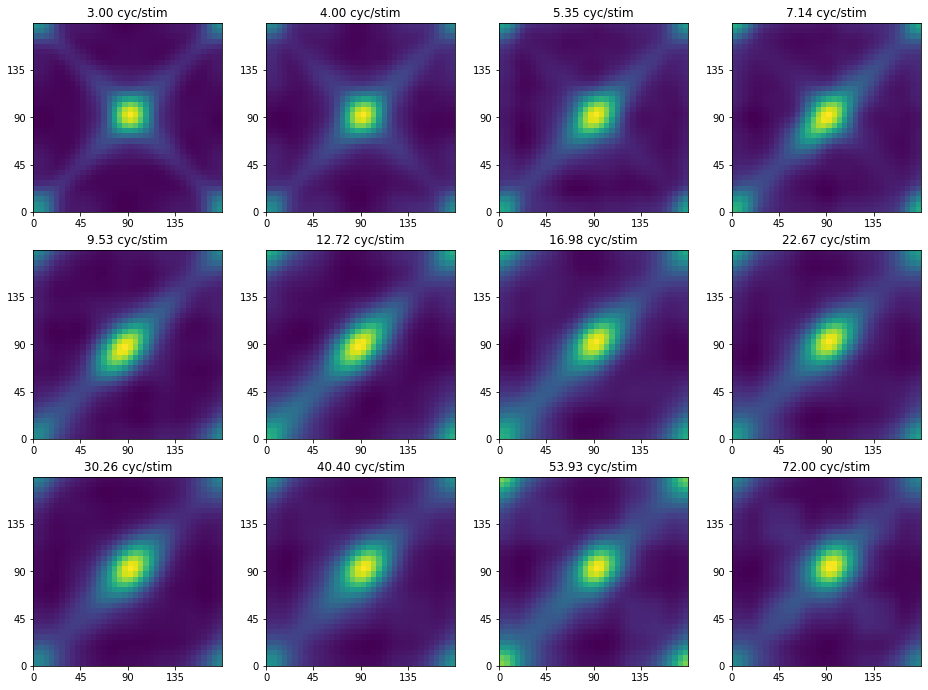

In [90]:
# visualizing just one SF at a time...

# trn_features_actual = scipy.stats.zscore(trn_features[:,0:n_features])
features_actual = features_each_model_val[:,:,best_model_ind]
plt.figure(figsize=(16,16));
# plotting one sf at a time to see within-sf orientation covariance...
for sf2plot in range(n_sf):

    covariance = np.cov(np.transpose(features_actual[:,sf_tuning_masks[sf2plot]]))
    plt.subplot(4,4,sf2plot+1)
    plt.pcolormesh(covariance)
#     plt.colorbar()
    plt.axis('square')
    plt.xticks(np.arange(0,35,9),labels=np.arange(0,179,45))
    plt.yticks(np.arange(0,35,9),labels=np.arange(0,179,45))
    plt.title('%.2f cyc/stim'%(cyc_per_stim[sf2plot]))

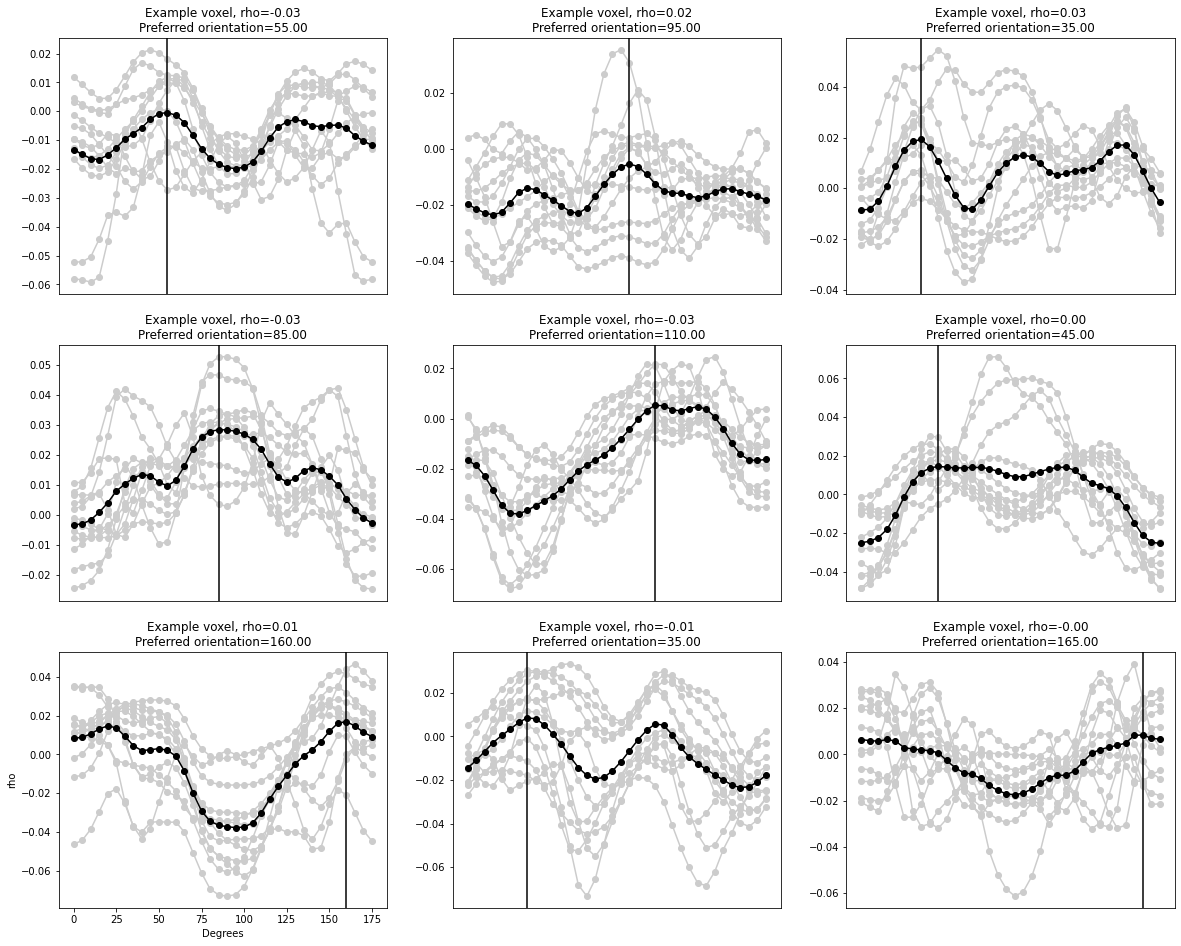

In [91]:
# Plotting orient tuning for several example voxels (based on correlation of resp with orientation channel activation)
n2plot = 9 
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

# vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    plt.plot(orients_deg, allcorrs_reshaped[vv,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(orients_deg, mean_orient_corrs[vv,:],'-o',color='k')
#     plt.plot(orients_deg, mean_orient_corrs[vv,:], '-o')    
    plt.axvline(preferred_ori_corrs[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('Degrees')
        plt.ylabel('rho')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    plt.title('Example voxel, rho=%.2f\nPreferred orientation=%.2f'%(val_cc[vv], preferred_ori_corrs[vv]))


[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175.]
[59 38 19 34 19 21 23 19 22 22 29 28 24 23 32 20 31 41 69 45 31 25 39 30
 21 27 18 15 20 26 13 18 28 23 15 33]
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175.]
[54 75 78 49 28 12  8  6  8 13 10  7  3 10 21 45 53 55 31 49 38 45 17  8
  7  4 10  9  8  6  4  8 23 63 71 64]


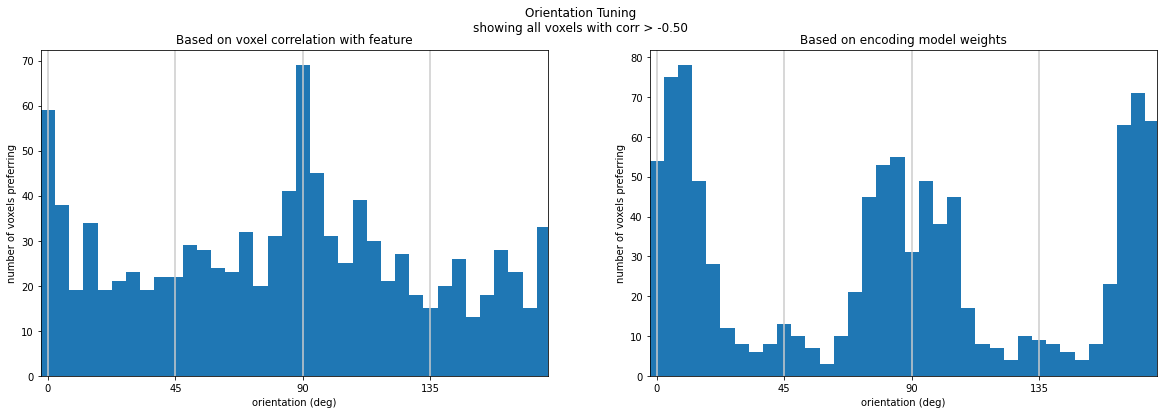

In [92]:
# Plot histogram of the orientation "tuning preferences" based on correlation coefficients
plt.figure(figsize=(20,6))

cc_cutoff = -0.5
abv_thresh = val_cc>cc_cutoff

plt.subplot(1,2,1)
h = plt.hist(np.round(preferred_ori_corrs[abv_thresh],0), bins=np.arange(0,180+180/n_ori,180/n_ori) );
unvals, counts = np.unique(preferred_ori_corrs[abv_thresh], return_counts=True)
print(unvals)
print(counts)

plt.xticks(np.arange(0,179,45)+180/n_ori/2, np.arange(0,179,45))
plt.xlim([0,179])
plt.xlabel('orientation (deg)')
plt.ylabel('number of voxels preferring')
plt.title('Based on voxel correlation with feature')
for ii in np.arange(0,181,45):
    plt.axvline(ii+180/n_ori/2,color=[0.8, 0.8, 0.8])
    
plt.subplot(1,2,2)
h = plt.hist(np.round(preferred_ori_weights[abv_thresh],1), bins=np.arange(0,180+180/n_ori,180/n_ori) );
unvals, counts = np.unique(preferred_ori_weights[abv_thresh], return_counts=True)
print(unvals)
print(counts)

plt.xticks(np.arange(0,179,45)+180/n_ori/2, np.arange(0,179,45))
plt.xlim([0,179])
plt.xlabel('orientation (deg)')
plt.ylabel('number of voxels preferring')
plt.title('Based on encoding model weights')
for ii in np.arange(0,181,45):
    plt.axvline(ii+180/n_ori/2,color=[0.8, 0.8, 0.8])
    
plt.suptitle('Orientation Tuning\nshowing all voxels with corr > %.2f'%cc_cutoff);

In [93]:
# Plot histogram of the orientation "tuning preferences" based on correlation coefficients
plt.figure(figsize=(24,16))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

cc_cutoff = -0.5

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
    h = plt.hist(np.round(preferred_ori_corrs[inds2use],0), bins=np.arange(0,180+180/n_ori,180/n_ori) );
    unvals, counts = np.unique(preferred_ori_corrs[inds2use], return_counts=True)

    plt.xticks(np.arange(0,179,45)+180/n_ori/2, np.arange(0,179,45))
    plt.xlim([0,179])
    if rr==n_rois-2:
        plt.xlabel('orientation (deg)')
        plt.ylabel('number of voxels preferring')
    else:
        plt.xticks([])
        plt.yticks([])
        
    for ii in np.arange(0,181,45):
        plt.axvline(ii+180/n_ori/2,color=[0.8, 0.8, 0.8])
    
    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds2use)))

plt.suptitle('Orientation Tuning\nshowing all voxels with corr > %.2f'%cc_cutoff);

ValueError: operands could not be broadcast together with shapes (11694,) (1000,) 

<Figure size 1728x1152 with 0 Axes>

In [94]:
# Plot histogram of the orientation "tuning preferences" based on correlation coefficients
plt.figure(figsize=(24,16))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

cc_cutoff = -0.5

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
    h = plt.hist(np.round(preferred_ori_weights[inds2use],0), bins=np.arange(0,180+180/n_ori,180/n_ori) );
    unvals, counts = np.unique(preferred_ori_weights[inds2use], return_counts=True)

    plt.xticks(np.arange(0,179,45)+180/n_ori/2, np.arange(0,179,45))
    plt.xlim([0,179])
    if rr==n_rois-2:
        plt.xlabel('orientation (deg)')
        plt.ylabel('number of voxels preferring')
    else:
        plt.xticks([])
        plt.yticks([])
        
    for ii in np.arange(0,181,45):
        plt.axvline(ii+180/n_ori/2,color=[0.8, 0.8, 0.8])
    
    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds2use)))

plt.suptitle('Orientation Tuning based on encoding model wts\nshowing all voxels with corr > %.2f'%cc_cutoff);

ValueError: operands could not be broadcast together with shapes (11694,) (1000,) 

<Figure size 1728x1152 with 0 Axes>

In [83]:
unvals


array([ 20.,  25.,  30.,  35.,  45.,  50.,  60.,  75.,  95., 100., 125.,
       135., 140., 145., 150., 155., 160.])

In [84]:
counts

array([3, 8, 3, 5, 2, 1, 1, 1, 1, 2, 1, 1, 8, 8, 4, 5, 1])

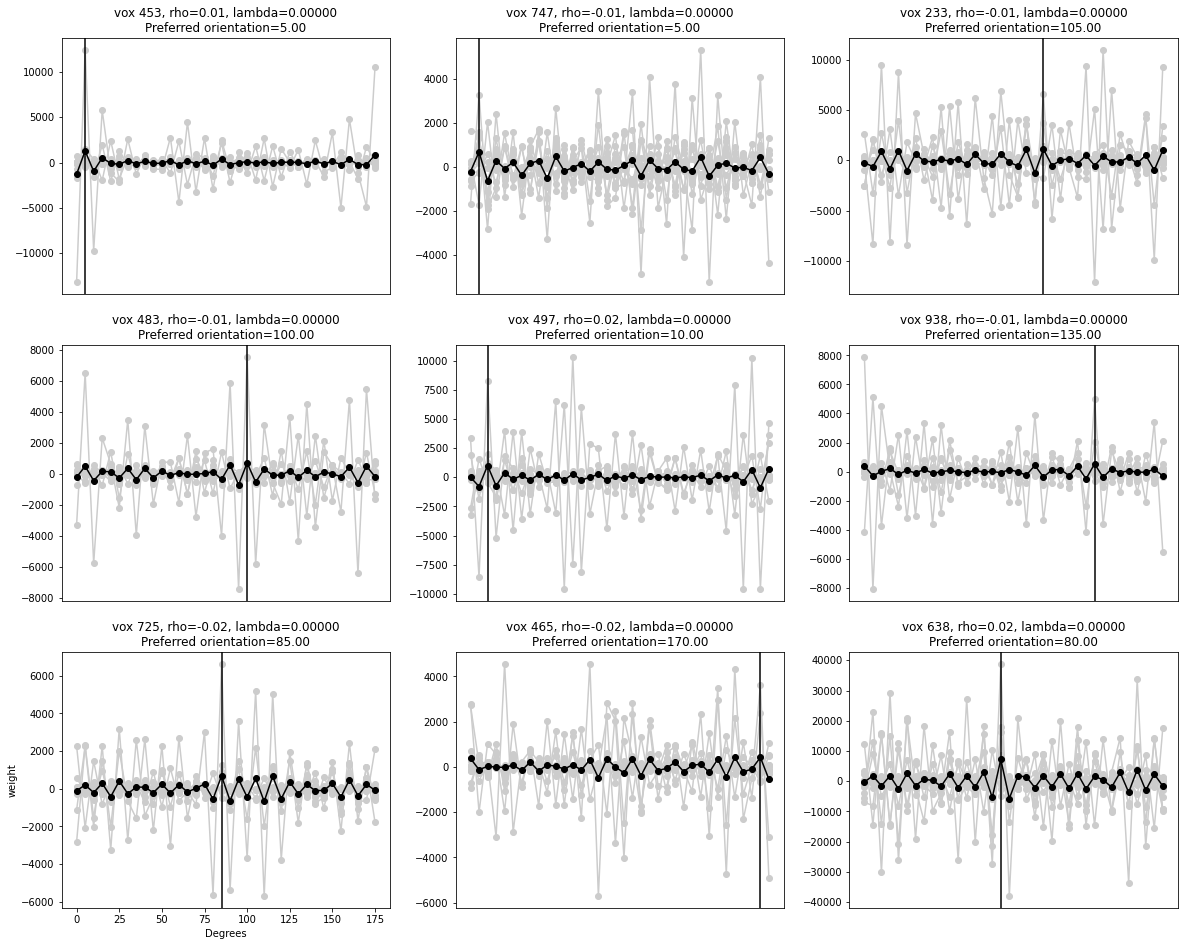

In [95]:
# Plotting orientation tuning for several example voxels (based on encoding model wts)
n2plot = 9
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

# vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    plt.plot(orients_deg, allw_reshaped[vv,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(orients_deg, mean_orient_weights[vv,:],'-o',color='k')  
    plt.axvline(preferred_ori_weights[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('Degrees')
        plt.ylabel('weight')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    plt.title('vox %d, rho=%.2f, lambda=%.5f\nPreferred orientation=%.2f'%(vv,val_cc[vv], lambdas[best_lambdas[vv]],preferred_ori_weights[vv]))


Text(0.5, 1.0, 'vox 146, rho=0.07, lambda=0.00000\nPreferred orientation=170.00')

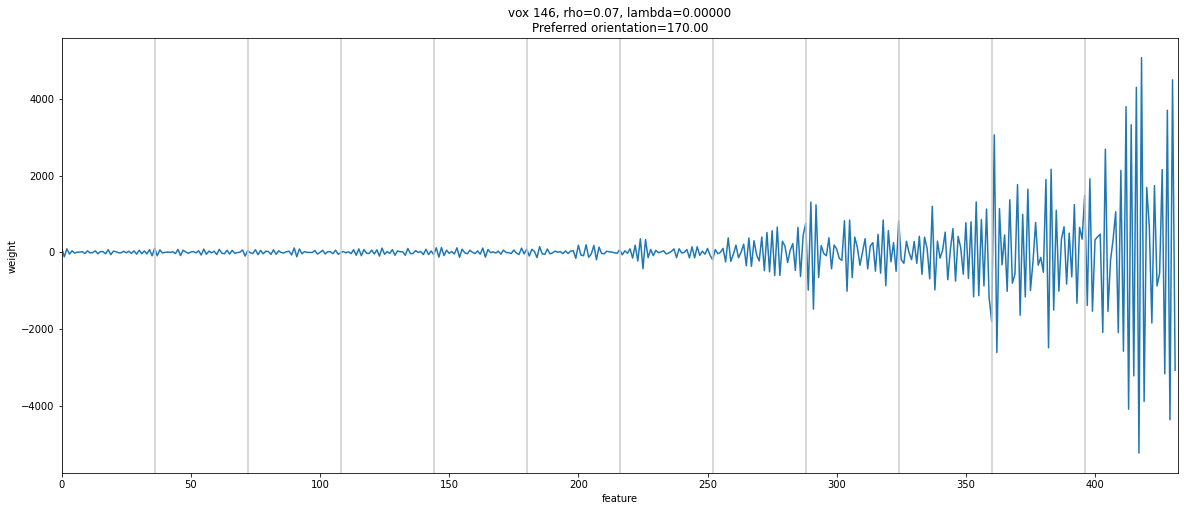

In [96]:
# Plot all feature weights for one voxel
vox2plot = np.argsort(val_cc)[-2:-1]
# vox2plot = np.random.randint(0,len(val_cc),n2plot)
vidx=  vox2plot[0]

plt.figure(figsize=(20,8));

weights = feature_weights[vidx,:]
plt.plot(weights)
for ii in np.arange(0,432,36):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
plt.xlim([0,432])
plt.xlabel('feature')
plt.ylabel('weight')
plt.title('vox %d, rho=%.2f, lambda=%.5f\nPreferred orientation=%.2f'%(vidx,val_cc[vidx], lambdas[best_lambdas[vidx]],preferred_ori_weights[vidx]))


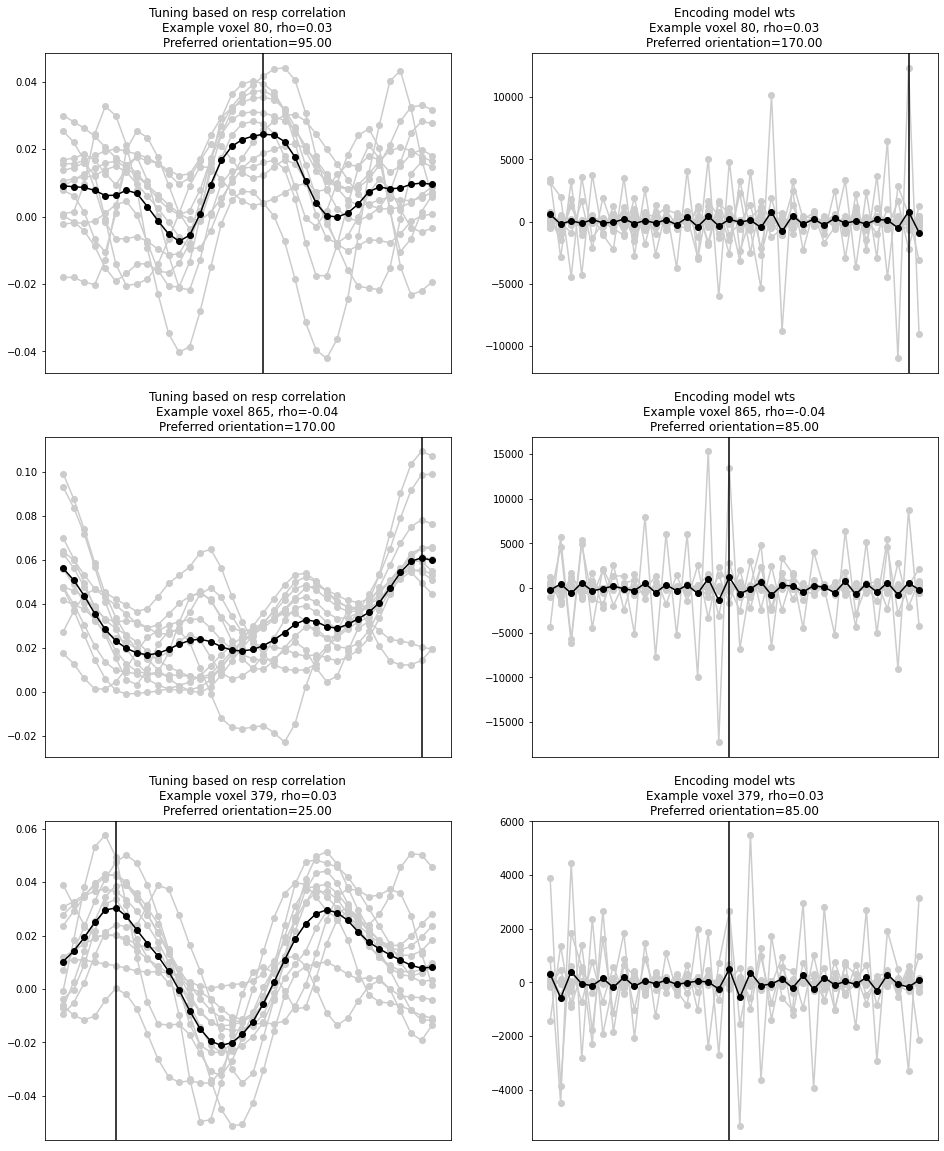

In [97]:
# Compare two methods of tuning side by side
n2plot = 3
npx = n2plot
npy = 2
# npx = int(np.ceil(np.sqrt(n2plot)))
# npy = int(np.ceil(n2plot/npx))

# vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(16,20))
for vi, vv in enumerate(vox2plot):   

    plt.subplot(npx, npy, (2*vi)+1)   
    plt.plot(orients_deg, allcorrs_reshaped[vv,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(orients_deg, mean_orient_corrs[vv,:],'-o',color='k')
#     plt.plot(orients_deg, mean_orient_corrs[vv,:], '-o')    
    plt.axvline(preferred_ori_corrs[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('Degrees')
        plt.ylabel('rho')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    plt.title('Tuning based on resp correlation\nExample voxel %d, rho=%.2f\nPreferred orientation=%.2f'%(vv, val_cc[vv], preferred_ori_corrs[vv]))

    plt.subplot(npx, npy, (2*vi)+2)   
    plt.plot(orients_deg, allw_reshaped[vv,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(orients_deg, mean_orient_weights[vv,:],'-o',color='k')
#     plt.plot(orients_deg, mean_orient_corrs[vv,:], '-o')    
    plt.axvline(preferred_ori_weights[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('Degrees')
        plt.ylabel('weight')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    plt.title('Encoding model wts\nExample voxel %d, rho=%.2f\nPreferred orientation=%.2f'%(vv, val_cc[vv], preferred_ori_weights[vv]))


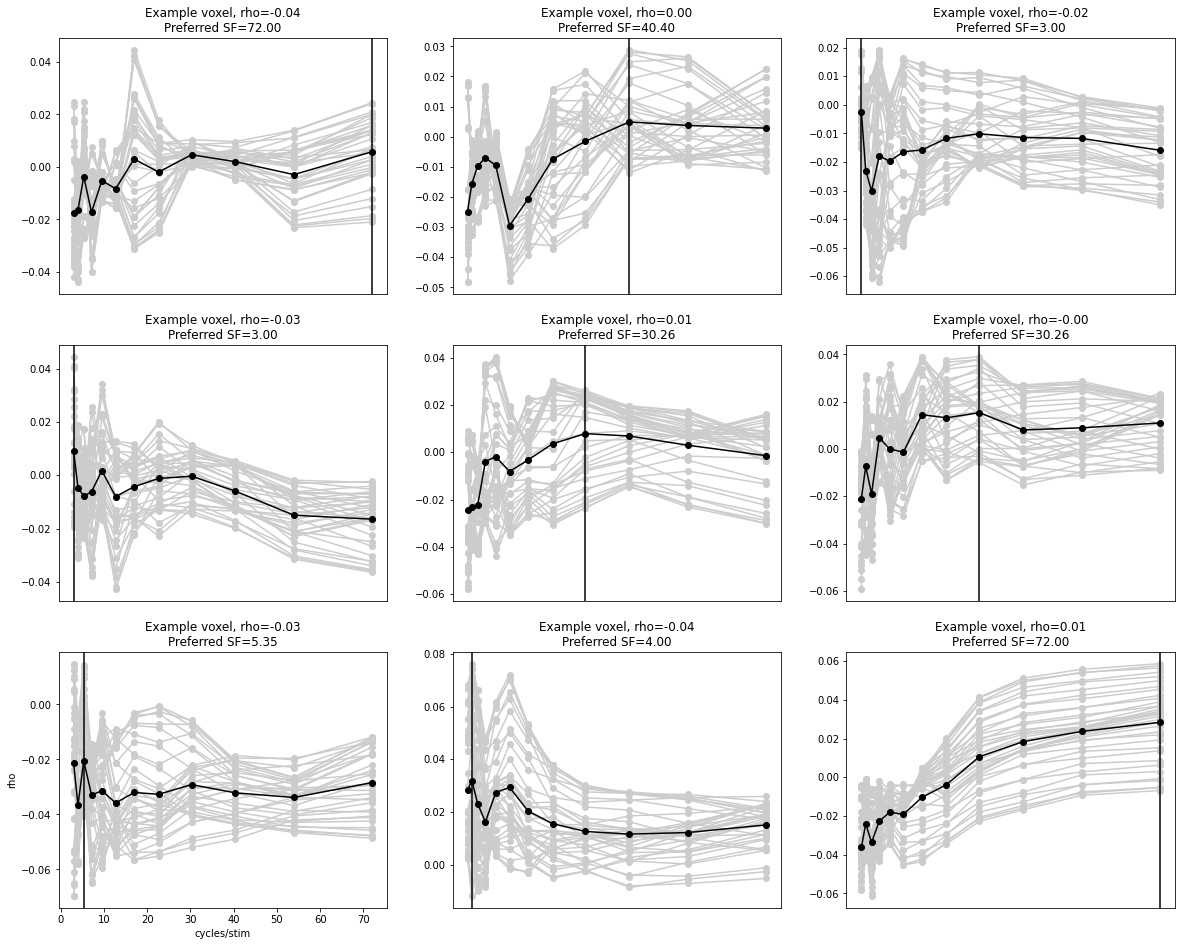

In [98]:
# Plotting SF tuning for several example voxels (based on correlation of resp with SF channel activation)
n2plot = 9 
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

# vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    plt.plot(cyc_per_stim, np.transpose(allcorrs_reshaped[vv,:,:]),'-o',color=[0.8, 0.8, 0.8])
    plt.plot(cyc_per_stim, mean_sf_corrs[vv,:],'-o',color='k')
#     plt.plot(orients_deg, mean_orient_corrs[vv,:], '-o')    
    plt.axvline(preferred_sf_corrs[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('cycles/stim')
        plt.ylabel('rho')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    plt.title('Example voxel, rho=%.2f\nPreferred SF=%.2f'%(val_cc[vv], preferred_sf_corrs[vv]))


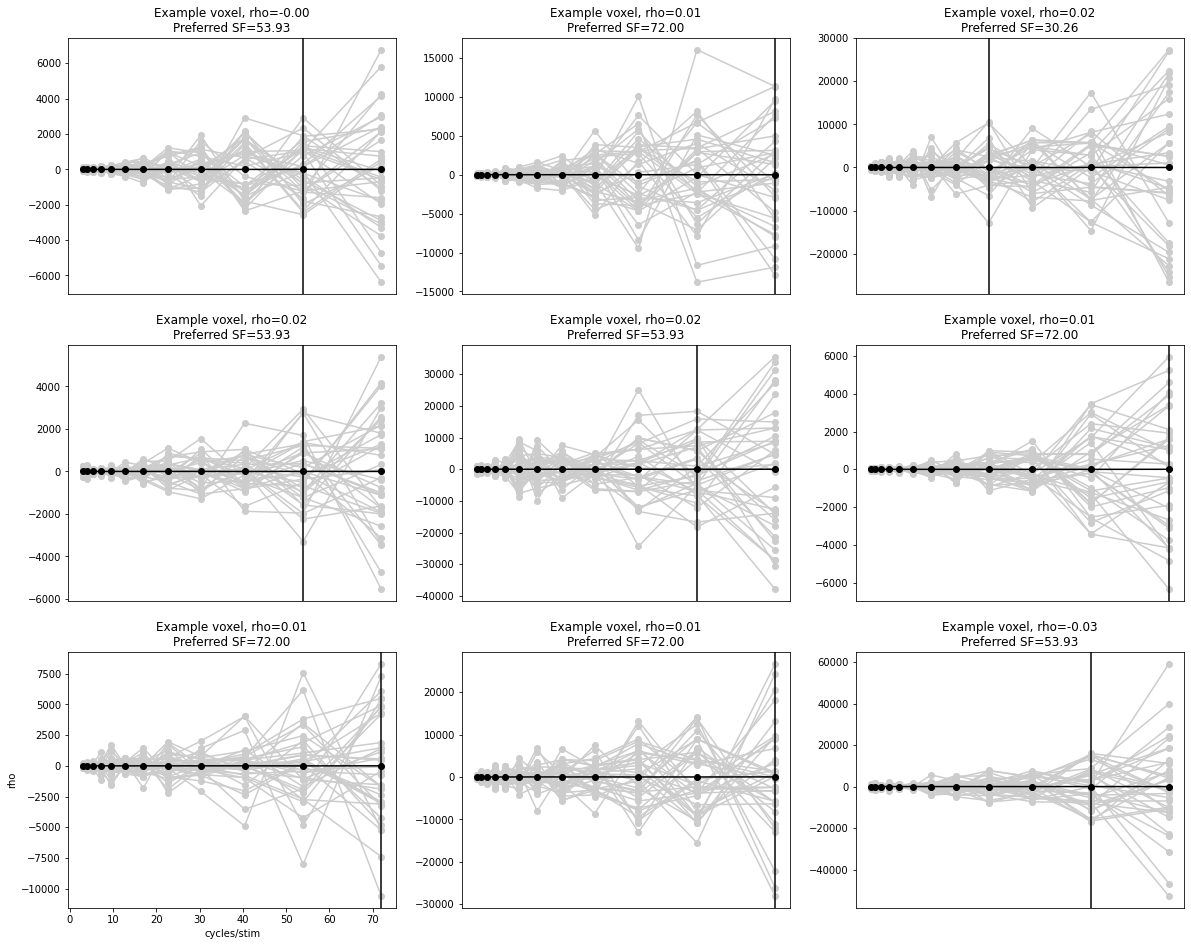

In [99]:
# Plotting SF tuning for several example voxels (based on encoding model wts);
n2plot = 9 
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

# vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    plt.plot(cyc_per_stim, np.transpose(allw_reshaped[vv,:,:]),'-o',color=[0.8, 0.8, 0.8])
    plt.plot(cyc_per_stim, mean_sf_weights[vv,:],'-o',color='k')
#     plt.plot(orients_deg, mean_orient_corrs[vv,:], '-o')    
    plt.axvline(preferred_sf_weights[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('cycles/stim')
        plt.ylabel('rho')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    plt.title('Example voxel, rho=%.2f\nPreferred SF=%.2f'%(val_cc[vv], preferred_sf_weights[vv]))


[ 3.         4.0049305  5.34649    7.1374407  9.528318  12.720084
 16.98102   22.669268  30.262949  40.400337  53.933517  72.       ]
[184 123  89  76  54  59  47  42  39  44  54 189]
[ 9.528318 12.720084 16.98102  22.669268 30.262949 40.400337 53.933517
 72.      ]
[  1   4  10  38 118 242 356 231]


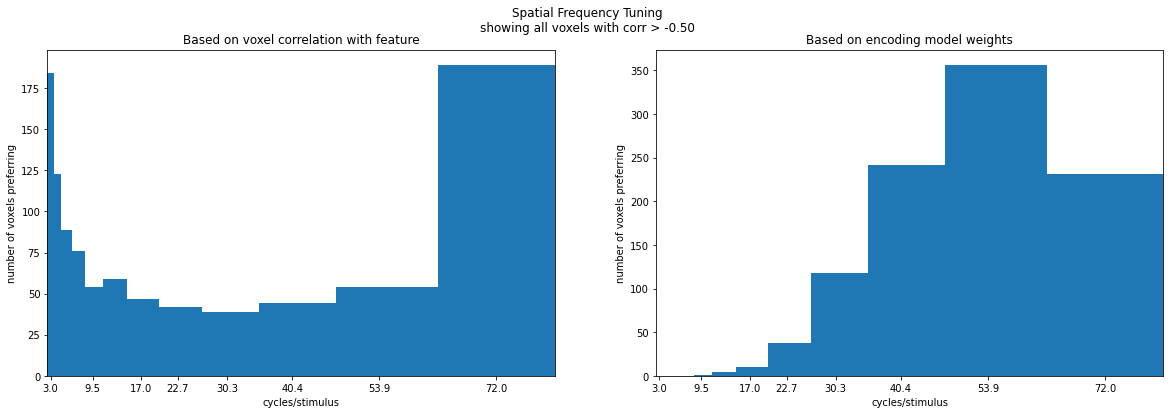

In [100]:
# Plot histogram of the "tuning preferences" based on correlation coefficient

cc_cutoff = -0.5
abv_thresh = val_cc>cc_cutoff


better_bin_edges = [cyc_per_stim[ii] - np.diff(cyc_per_stim[ii-1:ii+1])/2 for ii in np.arange(1,len(cyc_per_stim))]
better_bin_edges.insert(0, cyc_per_stim[0] - np.diff(cyc_per_stim[0:2])/2)
better_bin_edges.append(cyc_per_stim[-1] + np.diff(cyc_per_stim[-2:])/2)
better_bin_edges = np.squeeze(better_bin_edges)

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
h = plt.hist(np.round(preferred_sf_corrs[abv_thresh],0), bins=better_bin_edges );
unvals, counts = np.unique(preferred_sf_corrs[abv_thresh], return_counts=True)
print(unvals)
print(counts)
plt.xticks(np.round(cyc_per_stim[[0,4]+list(np.arange(6,n_sf))],1))
plt.xlim([np.min(better_bin_edges), np.max(better_bin_edges)])
plt.xlabel('cycles/stimulus')
plt.ylabel('number of voxels preferring')
plt.title('Based on voxel correlation with feature')

plt.subplot(1,2,2)
h = plt.hist(np.round(preferred_sf_weights[abv_thresh],1), bins=better_bin_edges );
unvals, counts = np.unique(preferred_sf_weights[abv_thresh], return_counts=True)
print(unvals)
print(counts)
plt.xticks(np.round(cyc_per_stim[[0,4]+list(np.arange(6,n_sf))],1))
plt.xlim([np.min(better_bin_edges), np.max(better_bin_edges)])
plt.xlabel('cycles/stimulus')
plt.ylabel('number of voxels preferring')
plt.title('Based on encoding model weights')

plt.suptitle('Spatial Frequency Tuning\nshowing all voxels with corr > %.2f'%cc_cutoff);

In [101]:
# Plot histogram of the sf "tuning preferences" based on correlation coefficients
plt.figure(figsize=(24,16))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

better_bin_edges = [cyc_per_stim[ii] - np.diff(cyc_per_stim[ii-1:ii+1])/2 for ii in np.arange(1,len(cyc_per_stim))]
better_bin_edges.insert(0, cyc_per_stim[0] - np.diff(cyc_per_stim[0:2])/2)
better_bin_edges.append(cyc_per_stim[-1] + np.diff(cyc_per_stim[-2:])/2)
better_bin_edges = np.squeeze(better_bin_edges)


cc_cutoff = -0.5

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
    h = plt.hist(np.round(preferred_sf_corrs[inds2use],0), bins=better_bin_edges);
    
    plt.xticks(np.round(cyc_per_stim[[0,4]+list(np.arange(6,n_sf))],1))
    plt.xlim([np.min(better_bin_edges), np.max(better_bin_edges)])
    
    if rr==n_rois-2:
        plt.xlabel('cycles/stimulus')
        plt.ylabel('number of voxels preferring')
    else:
        plt.xticks([])
        plt.yticks([])
        
    for ii in np.arange(0,181,45):
        plt.axvline(ii+180/n_ori/2,color=[0.8, 0.8, 0.8])
    
    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds2use)))

plt.suptitle('Spatial Freq Tuning\nshowing all voxels with corr > %.2f'%cc_cutoff);

ValueError: operands could not be broadcast together with shapes (11694,) (1000,) 

<Figure size 1728x1152 with 0 Axes>